# Practical 5: Language Modelling

Language models attempt to create a generalised long-term model of language. That is, a model that has learned the characteristics of the language it was trained on, such as grammar, punctuation, the relationship between words and so on. Typically, language models predict the next token of a sequence, given the previous tokens, or simply calculate the probability of a sequence of tokens. This can be implemented with a simple n-gram language model, but these are limited to predicting only sequences of n-grams (word combinations) observed within the training data.

In contrast, ML language models are much more robust and capable of generating more varied and 'imaginative' texts. RNN are well suited to this task due to their sequential processing of input. However, modern stat-of-the-art language models, such as [GPT-3](https://openai.com/blog/gpt-3-apps/), typically use [Transformers](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)). In either case LM are typically trained on very large natural language datasets, such as Wikipedia, Amazon reviews, Google books, or in our case Sherlock Holmes stories! Importantly, and similar to word vectors, once trained, the model of language that has been learned can be transfered to other downstream tasks, such as classification and translation.

In the first part of this practical we will create two n-gram language models. The first will simply calculate the probability of an input sentence, given the training corpus. The second will generate the next word, given the previous words in a sequence.

In the second part of this practical we will create an RNN language model using the complete works of [Sherlock Holmes by Sir Aurthur Conan Doyle](https://sherlock-holm.es/) as a training corpus. Then we will use the trained model to generate sentences in the style of Conan Doyle, and explore various different methods of sampling from the word probabilities generated by the model.

The objectives of this practical are:
1. Understand the key concepts of language modelling and evaluation: calculating the probability of a sentence or next token and calculating perplexity

2. Introduce new ML techniques that are usefull for building large models: data generators, custom metrics, early stopping and checkpointing

3. Compare and contrast different sampling methods, such as greedy, temperature and top-k

# 1 N-gram Language Models

## 1.0 Import libraries

In [63]:
import numpy as np
from collections import Counter
from nltk import ngrams

## 1.1 Probability of a sentence

We can create simple language models using n-grams. Whether we are calculating the probability of a sequence, or trying to predict the next word, the first step is the same: calculate the probability of a word given the previous word (bi-gram), or words (tri-gram +).

So, for each n-gram within the training corpus we need to calculate:

$P(word|previous \; words) = \frac{count(previous \; words, \; word)}{count(previous \; words)}$

The language model is then effectively the set of n-gram probabilites that have been calculated.

In [105]:
# Define the corpus
corpus = ['This is a dog', 'This is a cat', 'I love my cat', 'I love my dog', 'This is my name']

# Count the unigrams and n-grams
N = 2
n_grams = []
uni_grams = []
for sent in corpus:
    tokens = sent.lower().split()
    n_grams.extend(list(ngrams(tokens, N)))
    uni_grams.extend(tokens)

n_gram_count = Counter(n_grams)
print(f"{N}-grams: {n_gram_count}")
uni_gram_count = Counter(uni_grams)
print(f"Uni-grams: {uni_gram_count}")

# Calculate the n-gram probabilities
n_gram_probs = {}
for n_gram in n_grams:
    n_gram_probs[n_gram] = n_gram_count[n_gram] / uni_gram_count[n_gram[0]]
    print(f"P({n_gram[1:]}|{n_gram[0]}) = {n_gram_probs[n_gram]}")

2-grams: Counter({('this', 'is'): 3, ('is', 'a'): 2, ('i', 'love'): 2, ('love', 'my'): 2, ('a', 'dog'): 1, ('a', 'cat'): 1, ('my', 'cat'): 1, ('my', 'dog'): 1, ('is', 'my'): 1, ('my', 'name'): 1})
Uni-grams: Counter({'this': 3, 'is': 3, 'my': 3, 'a': 2, 'dog': 2, 'cat': 2, 'i': 2, 'love': 2, 'name': 1})
P(('is',)|this) = 1.0
P(('a',)|is) = 0.6666666666666666
P(('dog',)|a) = 0.5
P(('is',)|this) = 1.0
P(('a',)|is) = 0.6666666666666666
P(('cat',)|a) = 0.5
P(('love',)|i) = 1.0
P(('my',)|love) = 1.0
P(('cat',)|my) = 0.3333333333333333
P(('love',)|i) = 1.0
P(('my',)|love) = 1.0
P(('dog',)|my) = 0.3333333333333333
P(('is',)|this) = 1.0
P(('my',)|is) = 0.3333333333333333
P(('name',)|my) = 0.3333333333333333


Once we have calculated the n-gram probabilities calculating the probability of a sentence is simply:

1. Count the n-grams in the input sentence

2. Find the product of all n-grams that exist within both the model and the input sentence

In [109]:
# Sentence to calculate probability of
sentence = "This is my dog"

# Count n-grams
sentence_n_grams = list(ngrams([token.lower() for token in sentence.split()], N))
print(f"{N}-grams: {sentence_n_grams}")

# Calculate probability of sentence
probability = 1
# For each n-gram in sentence
for n_gram in sentence_n_grams:

    # If its probability is in the training corpus
    if n_gram in n_gram_probs:
        print(f"{N}-gram: {n_gram} probability: {round(n_gram_probs[n_gram], 3)}")

        # Multiply the probability of the n-gram to the total probability
        probability *= n_gram_probs[n_gram]

print(f"Probablility of sentence \"{sentence}\" = {round(probability, 3)}")

2-grams: [('this', 'is'), ('is', 'my'), ('my', 'dog')]
2-gram: ('this', 'is') probability: 1.0
2-gram: ('is', 'my') probability: 0.333
2-gram: ('my', 'dog') probability: 0.333
Probablility of sentence "This is my dog" = 0.111


## 1.2 Probability of next word

To calculate the probability of the next word in a sequence we need to build a language model in the same manner as before, by finding the probability of a word given the previous word(s):

$P(word|previous \; words) = \frac{count(previous \; words, \; word)}{count(previous \; words)}$

Note that here we have added two special tokens, `<s>` signifies the start of a sentence and `</s>` the end. This is often useful when generating text because it provides a generic starting, and potentially end point, for the generation process. Otherwise you would always need to provide a starting token/word, such as 'I', and this would influence selection of the following tokens.

In [110]:
# Define the corpus
corpus = ['<s> I am Sam </s>', '<s> Sam I am </s>', '<s> I do not like green eggs and ham </s>']

# Calculate the unigram and n-gram counts
N = 2
n_grams = []
uni_grams = []
for sent in corpus:
    tokens = sent.lower().split()
    n_grams.extend(list(ngrams(tokens, N)))
    uni_grams.extend(tokens)

n_gram_count = Counter(n_grams)
print(f"{N}-grams: {n_gram_count}")
uni_gram_count = Counter(uni_grams)
print(f"Uni-grams: {uni_gram_count}")

# Calculate the n-gram probabilities
n_gram_probs = {}
for n_gram in n_grams:
    n_gram_probs[n_gram] = n_gram_count[n_gram] / uni_gram_count[n_gram[0]]
    print(f"P({n_gram[1:]}|{n_gram[0]}) = {n_gram_probs[n_gram]}")

2-grams: Counter({('<s>', 'i'): 2, ('i', 'am'): 2, ('am', 'sam'): 1, ('sam', '</s>'): 1, ('<s>', 'sam'): 1, ('sam', 'i'): 1, ('am', '</s>'): 1, ('i', 'do'): 1, ('do', 'not'): 1, ('not', 'like'): 1, ('like', 'green'): 1, ('green', 'eggs'): 1, ('eggs', 'and'): 1, ('and', 'ham'): 1, ('ham', '</s>'): 1})
Uni-grams: Counter({'<s>': 3, 'i': 3, '</s>': 3, 'am': 2, 'sam': 2, 'do': 1, 'not': 1, 'like': 1, 'green': 1, 'eggs': 1, 'and': 1, 'ham': 1})
P(('i',)|<s>) = 0.6666666666666666
P(('am',)|i) = 0.6666666666666666
P(('sam',)|am) = 0.5
P(('</s>',)|sam) = 0.5
P(('sam',)|<s>) = 0.3333333333333333
P(('i',)|sam) = 0.5
P(('am',)|i) = 0.6666666666666666
P(('</s>',)|am) = 0.5
P(('i',)|<s>) = 0.6666666666666666
P(('do',)|i) = 0.3333333333333333
P(('not',)|do) = 1.0
P(('like',)|not) = 1.0
P(('green',)|like) = 1.0
P(('eggs',)|green) = 1.0
P(('and',)|eggs) = 1.0
P(('ham',)|and) = 1.0
P(('</s>',)|ham) = 1.0


Once we have created the model, by calculating the n-gram probabilities, we can use it to generate text:

1. First start with the seed tokens/text which will 'prompt' the model for the next token. In this case we can simply use the start of a sentence token (`<s>`).

2. Loop until the end of sentence token (`</s>`) is generated, or a maximum sequence length is reached. At each step:

    1. Find *all* the possible next tokens given the previous token.

    2. Select the next token using the chosen sampling method.

    3. Add the selected token to the generated text.


In [111]:
# Set the seed text
generated_text = "<s>"
# Variable to hold the next token
next_token = ''
# Set the maximum sequence length
max_seq_len = 10
# Set the sampling method
sampling_method = 'greedy'

# While next token is not end of sentence and max sequence length is not reached
i = 0
while next_token != '</s>' and i < max_seq_len:

    # Tokenize generated text
    tokens = generated_text.lower().split()

    possible_next_tokens = {}
    # Find possible next tokens
    for n_gram, prob in n_gram_probs.items():
        # If last token of generated text is the first token of n-gram
        if n_gram[0] == tokens[-1]:
            # Add n-gram to possible next tokens
            possible_next_tokens[n_gram[1]] = prob

    print('Possible tokens: ')
    print(possible_next_tokens)

    # Select next token
    # Greedy choice (highest probability)
    if sampling_method == 'greedy':
        next_token = list(sorted(possible_next_tokens.items(), key=lambda item: item[1]))[-1][0]

    print(f'Next token: {next_token}\n')

    # Add next token to generated text
    generated_text += ' ' + next_token
    i += 1

print('Generated text: ' + generated_text)

Possible tokens: 
{'i': 0.6666666666666666, 'sam': 0.3333333333333333}
Next token: i
Possible tokens: 
{'am': 0.6666666666666666, 'do': 0.3333333333333333}
Next token: am
Possible tokens: 
{'sam': 0.5, '</s>': 0.5}
Next token: sam
Possible tokens: 
{'</s>': 0.5, 'i': 0.5}
Next token: </s>
Generated text: <s> i am sam </s>


## 1.3 Exercise: Different sampling methods

The above algorithm uses a 'greedy' sampling method, which simply selects the most probable token from all possible next tokens. However, even with large sophisticated language models greedy sampling often results in generic and repetative text.

1. Extend the code to add a few other sampling methods. For example:

    1. 'eager', which selects the first possible token

    2. 'random', which randomly selects from all possible tokens
    
    3. Or even better, 'weighted_random', which randomly selects from all possible tokens weighted by the token probability. This can be simply implemented using `np.random.choice()`

# 2 RNN ('Sherlock') Language Models

## 2.0 Import libraries

In [1]:
import os
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as gen
import tensorflow as tf
from collections import Counter
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

# Set the directory to the data folder
data_dir = os.path.join('..', 'data', 'sherlock')

# # Spacy needs to install the language model also
# # If you recieve an error, uncomment the following line and re-run the cell
# # !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

## 2.1 Load and pre-process data

The data directory should contain the complete works of Sherlock Holmes as a set of text files. We will simply loop over each file, tokenise into sentences, lowercase all words and remove extra whitespace.

In [2]:
print('Loading texts from files: ' + str(os.listdir(data_dir)))

# Load the data
sentences = []
for file_name in os.listdir(data_dir):
    with open(os.path.join(data_dir, file_name), 'r') as file:
        doc = nlp(file.read().replace('\n', ' '))

        # Tokenize the sentences
        for sent in doc.sents:
            # Remove whitespace tokens and lowercase
            tokens = [token.text.lower() for token in sent if not token.is_space]
            # After tokenizing and removing whitespace, remove sentences with only one token
            if len(tokens) > 1:
                sentences.append(tokens)

print('Number of sentences: ' + str(len(sentences)))
print('First 5 sentences: ')
for sent in sentences[0:5]:
    print(sent)

Loading texts from files: ['A Study in Scarlet.txt', 'His Last Bow.txt', 'The Adventures of Sherlock Holmes.txt', 'The Case-Book of Sherlock Holmes.txt', 'The Hound of the Baskervilles.txt', 'The Memoirs of Sherlock Holmes.txt', 'The Return of Sherlock Holmes.txt', 'The Sign of Four.txt', 'The Valley of Fear.txt']
Number of sentences: 44016
First 5 sentences: 
['a', 'study', 'in', 'scarlet', 'arthur', 'conan', 'doyle', 'table', 'of', 'contents', 'part']
['i', 'mr.', 'sherlock', 'holmes', 'the', 'science', 'of', 'deduction', 'the', 'lauriston', 'garden', 'mystery']
['what', 'john', 'rance', 'had', 'to', 'tell', 'our', 'advertisement', 'brings', 'a', 'visitor', 'tobias', 'gregson', 'shows', 'what', 'he', 'can', 'do', 'light']
['in', 'the', 'darkness', 'part', 'ii']
['on', 'the', 'great', 'alkali', 'plain', 'the', 'flower', 'of', 'utah', 'john', 'ferrier', 'talks', 'with', 'the', 'prophet', 'a', 'flight', 'for', 'life', 'the', 'avenging', 'angels', 'a', 'continuation', 'of', 'the', 'remin

We can plot the distribution of sentence lengths to determin how long the input sequences should be.

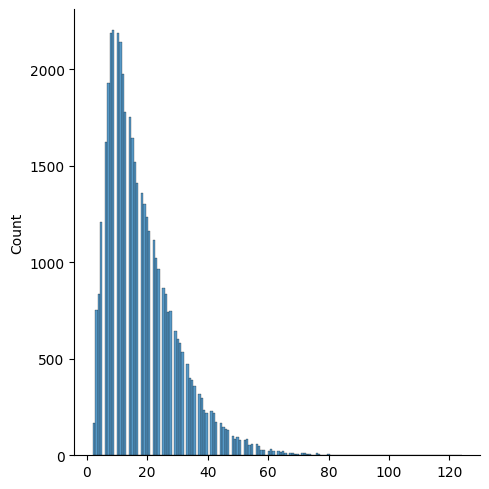

In [3]:
# Plot the distribution of sentence lengths
seq_lengths = [len(sent) for sent in sentences]
sns.displot(seq_lengths, kind='hist')
plt.show()

### Build a vocabulary

Create a vocabulary as before. For language modelling, increasing the vocabulary size greatly increases the complexity of the task, because each output prediction is a word from the vocabulary. So a vocabulary size of 10k is effectively a classification problem with 10k classes! However, if the vocabulary is too small the model will not be able to learn a sufficient number of words to generate interesting/meaningfull text.

In [4]:
def create_vocabulary(corpus, vocab_size=None, min_freq=1, special_tokens=None):

    # Count the frequency of each token in the corpus
    word_counter = Counter()
    for sent in corpus:
        word_counter.update(sent)

    if min_freq > 1:
        # Remove tokens that occur less than min_freq times
        word_counter =  Counter({word: count for word, count in word_counter.items() if count >= min_freq})

    # Create a vocabulary
    vocab = []
    vocab_size = len(word_counter) if vocab_size is None else vocab_size

    # Add the special tokens to the vocabulary
    if special_tokens and isinstance(special_tokens, list):
        vocab.extend(special_tokens)
    else:
        special_tokens = []

    # Add the vocab_size most common tokens to the vocabulary
    vocab.extend([word for word, count in word_counter.most_common(vocab_size - len(special_tokens))])

    return vocab

# Create a vocabulary
vocab = create_vocabulary(sentences, vocab_size=None, min_freq=1, special_tokens=['<pad>', '<unk>', '<s>', '</s>'])

# Print the vocabulary
print("Vocabulary size: " + str(len(vocab)))
for i, word in enumerate(vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')

Vocabulary size: 19724
(0, <pad>) (1, <unk>) (2, <s>) (3, </s>) (4, ,) (5, .) (6, the) (7, ") (8, and) (9, i) (10, of) (11, to) (12, a) (13, that) (14, it) (15, in) (16, he) (17, was) (18, you) (19, his) (20, is) (21, had) (22, have) (23, my) (24, with) (25, ?) (26, as) (27, for) (28, at) (29, -) (30, which) (31, we) (32, but) (33, not) (34, me) (35, this) (36, be) (37, there) (38, him) (39, ') (40, said) (41, holmes) (42, 's) (43, from) (44, no) (45, on) (46, one) (47, upon) (48, so) (49, all) 

## 2.2 Create a data generator

For many NLP tasks, which require large training datasets, it is impractical or infeasible to pre-process the entier dataset beforhand. In most cases the pre-processing time could be very long, but more importantly the data would not fit in memory!

Language modelling can be a good example of this. At each timestep we want to predict the next token in the sequence. So, for each sentence in our dataset we need to produce input sequences for each word in the sentence (+ the `<s>` and `</s>` tokens). For example, the sentence '*In the year 1878*' becomes:

- `<s>`

- `<s>` In

- `<s>` In the

- `<s>` In the year

- `<s>` In the year 1886

- `<s>` In the year 1886 `</s>`

So, the ~41k sentences in the dataset become ~800k! Not only would this take much longer to process but also considerably more memory.

To get around this problem we can use a Generator class (by subclassing a Keras Sequence class). A Generator *class* allow us to define how each batch of data is processed and this will be performed on-the-fly at runtime. A Generator *object* can be passed into `model.fit()` instead of lists/arrays of data (inputs and labels or x and y), and each batch will be 'consumed' by the model.

In the `LMDataGenerator` class below the key method is `__getitem__()`, which defines how each batch of data should be processed. In this case the sentences are vectorised, the `<s>` and `</s>` tokens added and then padded with the `<pad>` token to the `max_seq_len`. Each time the function is called it returns the `batch_size` of input sequences and expected outputs (target token).

Take some time to understand what the Generator class below is doing. Particularly the `__getitem__()` method.

<div class = "alert alert-block alert-info"><b>Note:</b> We could perform all pre-processing within the data generator, such as tokenisation and lowercasing. However, for simplicity and to allow the creation of a vocabulary, here we only preform the step which greatly increase memory requirements.</div>

In [6]:
class LMDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator for language modeling."""

    def __init__(self, data, vocab, max_seq_len, batch_size, shuffle=True):
        
        self.data = data
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get the data indexes and shuffle
        self.indexes = np.arange(len(self.data))
        self.on_epoch_end()
    
    def on_epoch_end(self):
        """Updates data after each epoch. Currently only shuffles data if shuffle=True."""
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        """Calculates the number of batches per epoch (num_tokens / batch_size)."""
        sum = np.sum([len(sent) for sent in self.data])
        return int(np.ceil(sum / self.batch_size))

    def __getitem__(self, index):
        """Generates a batch of data."""

        # Generate batch of inputs and outputs
        batch_inputs, batch_outputs = [], []
        i = 0
        while i < self.batch_size:

            # Get the sentence
            sent = self.data[self.indexes[index]]

            # Vectorise the sentences
            vectorised_sent = [self.vocab.index(word) if word in self.vocab else self.vocab.index('<unk>') for word in sent]
            # Add the start and end tokens
            vectorised_sent = [self.vocab.index('<s>')] + vectorised_sent + [self.vocab.index('</s>')]

            # Incrementally add each word in the vectorised sentence to the input batch
            # Add the next word to the output batch
            for j in range(1, len(sent) - 1):
                batch_inputs.append(vectorised_sent[:j])
                batch_outputs.append(vectorised_sent[j])

                # Increment the batch counter
                i += 1
                if i >= self.batch_size:
                    break
            
            # Increment the data index if we have not filled the batch
            if len(batch_inputs) < self.batch_size:
                index += 1 if index + 1 < len(self.data) else 0

        # Pad the sentences to the max_seq_len
        batch_inputs = pad_sequences(batch_inputs, maxlen=self.max_seq_len, padding='post', truncating='post', value=0.0)

        # Conver input/outputs to numpy arrays
        batch_inputs = np.array(batch_inputs)
        batch_outputs = np.array(batch_outputs)
        
        return batch_inputs, batch_outputs

# Set the maximum sequence length and batch size
max_seq_len = 80
batch_size = 128

# Create a data generator
data_generator = LMDataGenerator(sentences, vocab, max_seq_len=max_seq_len, batch_size=batch_size)

# Print the number of batches
print('Number of batches: ' + str(len(data_generator)))

# Print the first examples
inputs, outputs = data_generator[0]
print(inputs.shape)
print(outputs.shape)
for i in range(5):
    print('Input Sentence: ' + ' '.join([vocab[word] for word in inputs[i]]))
    print('Input Vector: ' + str(inputs[i]))
    print('Target Word: ' + str(vocab[outputs[i]]))
    print()

Number of batches: 6246
(128, 80)
(128,)
Input Sentence: <s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Input Vector: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Target Word: we

Input Sentence: <s> we <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

## 2.3 Create an embedding matrix

In [7]:
# Set the embedding dimension
embedding_dim = 300

# Load the word embeddings
glove_vectors = gen.load("glove-wiki-gigaword-" + str(embedding_dim))

# Generate the embedding matrix
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for i, word in enumerate(vocab):
    # Skip the padding token
    if i == 0:
        continue
    
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]
    else:
        embedding_matrix[i] = np.random.uniform(low=-1.0, high=1.0, size=embedding_dim)

print('Shape of embeddings:', embedding_matrix.shape)
print(embedding_matrix[:5])

Shape of embeddings: (19724, 300)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.29745131 -0.58824459 -0.82285656 ... -0.42817501 -0.37204594
  -0.31586437]
 [-0.92729657  0.40835539  0.5166385  ...  0.55271557 -0.60070922
  -0.04791399]
 [-0.84890795 -0.99841716 -0.83168475 ...  0.67454524 -0.50529898
   0.98968065]
 [-0.25538999 -0.25723001  0.13169    ... -0.23289999 -0.12226
   0.35499001]]


## 2.4 Build the RNN Language Model

The following cells define a simple LSTM language model, with similar architecture to those we have previously used: an embedding layer, followed by an LSTM layer, followed by a feed forward classification layer.

However, here we additionaly define a custom Metric class, to calculate during training (by subclassing a Keras Metrics class). A custom metric can be used in addition to the loss and accuracy metrics we have already seen.

In the `PerplexityMetric` class below we can define the Perplexity calculation for each timestep. Recall that perplexity is simply:

$PPL(P|Q) = 2^{H(P|Q)}$

Where $H(P|Q)$ is the entropy (loss) of the learned distribution Q given the actuall distribution P.

Perplexity can be considered a measure of a language models uncertainty when predicting the next word and is often a more informative metric than loss alone. A Perplexity of 10, for example, can be interpreted as the model choosing (or being uncertain) between 10 words in that situation.

In [8]:
class PerplexityMetric(tf.keras.metrics.Mean):
    """Custom metric for perplexity.
    Adapted from: https://gist.github.com/Gregorgeous/dbad1ec22efc250c76354d949a13cec3"""
    
    def __init__(self, name='perplexity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
    
    def _calculate_perplexity(self, real, pred):
        # Create a mask to ignore the padding tokens
        mask = tf.math.logical_not(tf.math.equal(real, 0))

        # Calculate the loss/entropy
        loss_ = self.cross_entropy(real, pred)

        # Apply the mask
        loss_ *= tf.cast(mask, dtype=loss_.dtype)

        # Calculate the perplexity
        mean_loss = tf.keras.backend.mean(loss_, axis=-1)
        perplexity = tf.keras.backend.exp(mean_loss)
        return perplexity

    def update_state(self, y_true, y_pred, sample_weight=None):
        perplexity = self._calculate_perplexity(y_true, y_pred)
        super().update_state(perplexity)

In [10]:

# Input layer takes in an integer vector of length max_seq_len
inputs = tf.keras.Input(shape=(max_seq_len,), dtype=tf.int32)

# Create the embedding layer
embedding_layer = layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    input_length=max_seq_len,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    mask_zero=True,
    trainable=True)(inputs)

# Recurrent layer
x = layers.LSTM(512, return_sequences=False)(embedding_layer)

# Classification layers
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(vocab), activation="softmax")(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='sherlock_lm')
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",  metrics=[PerplexityMetric()])
model.summary()

Model: "sherlock_lm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           5917200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1665024   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 19724)             10118412  
Total params: 17,700,636
Trainable params: 17,700,636
Non-trainable params: 0
_________________________________________________________________


### Train and evaluate the model

Here we train the model using `model.fit()`, as before, but with two key differences:

1. Notice the `data_generator` object, that was previously instantiated, replaces the input and output (or x and y) lists/arrays.

2. Two callbacks have been defined and passed to the fit function. Callbacks define code that is run after each training epoch or batch and can be useful for all kinds of purposes, such as saving training metrics to a file. In this case they are primarily intended to prevent overfitting.

    1. `ModelCheckpoint` saves the model during training. Crutially, we can specify a metric to `monitor`, such as loss, and only save the model if the loss is *lower* than the previous best. In this way, even if the model overfits during training, causing the loss to increase, we can load the 'best' model learned during training.

    2. `EarlyStopping` again allows for the monitoring of a training metric. In this case, in order to stop the training process if the metric shows no improvement for more than `patience` number of epochs. Thus, if we have reached a point where the model is beginning to overfit we can simply end the training process.

<div class = "alert alert-block alert-warning"><b>Warning:</b> **Please do not run this cell on UWE machines/CSCT cloud!**<br>
This training process can take a *very* long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU.  <br>Instead please either run this notebook on Google Colab, or skip this cell and load one of the pre-trained models provided (below).
</div>

In [ ]:
model_chkptr = tf.keras.callbacks.ModelCheckpoint(
    'sherlock_lm.h5',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch')

model_earlystp = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.01,
    patience=5,
    verbose=0,
    mode="min",
    restore_best_weights=False)

# Fit the model
results = model.fit(data_generator, epochs=30, callbacks=[model_chkptr, model_earlystp])

Best loss: 2.815
Best perplexity: 22.741


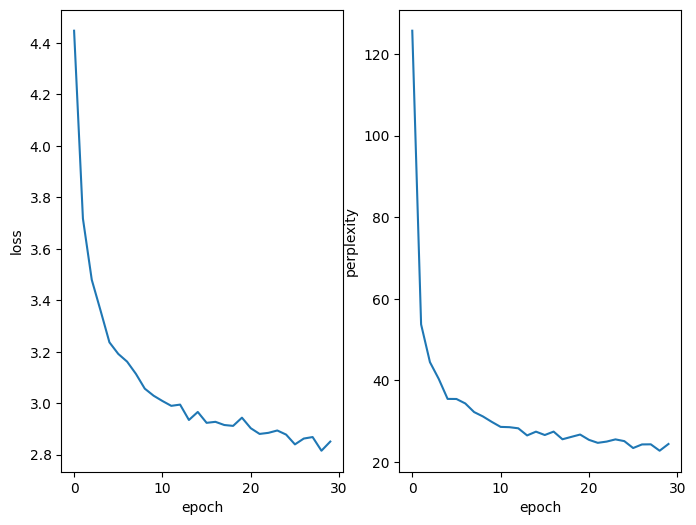

In [13]:
print('Best loss: ' + str(round(min(results.history['loss']), 3)))
print('Best perplexity: ' + str(round(min(results.history['perplexity']), 3)))

# Plot the training loss and perplexity
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
sns.lineplot(results.history['loss'], ax=ax[0])
ax[0].set(xlabel='epoch', ylabel='loss')
sns.lineplot(results.history['perplexity'], ax=ax[1])
ax[1].set(xlabel='epoch', ylabel='perplexity')
plt.show()

## 2.4 Generating text

Once the model is trained we can now use it to generate some text! First we should load the weights of the best model found during training. As previously discussed, due to the length of training time it is highly recommended you load one of the models provided:

sherlock_lm.h5:
 - Vocabulary size = 19k
 - Max sequence length = 80
 - Embedding dimension = 300
 - LSTM units = 512
 - Epochs = ~30
 - Perplexity = 17.496
 - Loss = 2.2

In [11]:
# Load the model
model.load_weights('sherlock_lm.h5')
print(model.summary())

Model: "sherlock_lm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           5917200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1665024   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 19724)             10118412  
Total params: 17,700,636
Trainable params: 17,700,636
Non-trainable params: 0
_________________________________________________________________
None


Now we can use the model to generate text just as we did in section 1.2:

1. First start with the seed tokens/text which will 'prompt' the model for the next token. In this case we can simply use the start of a sentence token (`<s>`).

2. Loop until the end of sentence token (`</s>`) is generated, or a maximum sequence length is reached. At each step:

    1. Vectorise and pad the sequence into the correct input format for the model.

    2. Generate predictions to find the probilities over *all* tokens in the vocabulary, given the previous tokens.

    2. Select the next token using the chosen sampling method.

    3. Add the selected token to the generated text.

In [17]:
# Set the seed text and next token to empty string
seed_text = '<s> '
next_token = ""

# Set the sampling parameters
sampling_method = "temp_nucleus"
temperature = 0.15
top_k = 20
top_p = 0.9

# Generate the next 
while next_token != "</s>" and len(seed_text.split()) < max_seq_len:

    # Vectorise the sentences
    input_sent = [vocab.index(word) if word in vocab else vocab.index('<unk>') for word in seed_text.split()]
    # Pad the sentences to the max_seq_len
    input_sent = pad_sequences([input_sent], maxlen=max_seq_len, padding='post', truncating='post', value=0.0)
    input_sent = np.array(input_sent)
    
    # Generate predictions
    predictions = model.predict(input_sent, verbose=0)

    # Sample the next token
    if sampling_method == "greedy":
        # Get the token with the highest probability
        predicted_token = np.argmax(predictions, axis=-1)

    elif sampling_method == "temperature":
        # Convert the predictions to logit space
        predictions = np.log(predictions[0],  where=predictions[0] > 0)

        # Apply softmax with temperature
        predictions = np.exp(predictions / temperature) / np.sum(np.exp(predictions / temperature))

        # Sample from the distribution
        predicted_token = np.random.choice(len(vocab), 1, p=predictions)

    # Convert the predicted token to a word
    next_token = vocab[predicted_token[0]]
    
    # Add the predicted word to the seed text
    seed_text += " " + next_token

# Print the generated text
print("Generated text: ", seed_text)

Generated text:  <s>  " i am sort to say that you have only been waiting for me at the last place , mr. holmes , " said the secretary , " you have had a word of my friend and mr. holmes , " he said , taking the go by the maid 's eyes , and the blood - honourable terrible had been left as a wire to make it , i could see the planned drawback , and he left


## 2.5 Exercise: Different sampling methods

Above Two sampling methods are defined, 'greedy' and 'temperature'.

1. Extend the code to add a few other sampling methods discussed in the lecture:

    1. 'top-k', which sorts tokens by probabilites and ignores anythin below the $k^{th}$ token

    2. 'nucleus', which sets a value for p in the range [0, 1]. Once the cumulative probability of tokens reaches p the rest are ignored
    
    3. Or even better, 'temp_nucleus', which applies temperature to the probabilities and then applies nucleus sampling.

    4. You can also try the 'weighted_random' that you developed previously.

2. Experiment with the parameters `temperature`, `top_k` and `top_p`, for their respective sampling methods and see which produce the most natural text in the style of Sherlock Holmes.